# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, roc_auc_score

In [12]:
data = pd.read_csv('/datasets/Churn.csv')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


| Название        | Описание                                          | Тип            | Нужен для обучения модели |
|-----------------|:--------------------------------------------------|----------------|---------------------------|
| RowNumber       | Индекс строки в данных                            | Категориальный | Нет                       |
| CustomerId      | Уникальный идентификатор клиента                  | Категориальный | Нет                       |
| Surname         | Фамилия                                           | Категориальный | Нет                       |
| CreditScore     | Кредитный рейтинг                                 | Количественный | Да                        |
| Geography       | Страна проживания                                 | Категориальный | Да                        |
| Gender          | Пол                                               | Категориальный | Да                        |
| Age             | Возраст                                           | Количественный | Да                        |
| Tenure          | Количество недвижимости у клиента                 | Количественный | Да                        |
| Balance         | Баланс на счёте                                   | Количественный | Да                        |
| NumOfProducts   | Количество продуктов банка, используемых клиентом | Количественный | Да                        |
| HasCrCard       | Наличие кредитной карты                           | Категориальный | Да                        |
| IsActiveMember  | Активность клиента                                | Категориальный | Да                        |
| EstimatedSalary | Предполагаемая зарплата                           | Количественный | Да                        |
| Exited          | Факт ухода клиента – _целевой признак_            | Категориальный | -                         |

In [14]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [15]:
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

На сайте Kaggle мы заметили, что признак Surname представлен 2 932 уникальными значениями. Убедимся в том, что всё-таки в нашем датасете все клиенты уникальные:

In [16]:
len(data['CustomerId'].unique())

10000

Тип данных признака Tenure – float64. Pandas при чтении датасета вывел данный тип из-за наличия пропусков. Результат обработки пропусков в датасете может повлиять на качество модели. Мы можем заполнить пропуски средним значением, что может привести к переобучению или же удалить ~10% объектов. Данных у нас не так мало, поэтому попробуем избавиться от пропусков, а также привести признак к целочисленному типу.

In [17]:
data.dropna(subset = ['Tenure'], inplace = True)
data['Tenure'] = data['Tenure'].astype('int')

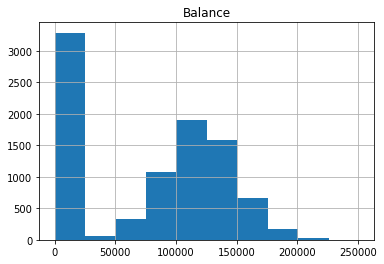

In [18]:
data.hist('Balance')
plt.show()

In [19]:
zero_balance = data.query('Balance == 0')
print('Клиентов с нулевым балансом:', len(zero_balance))
zero_balance.head()

Клиентов с нулевым балансом: 3283


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,101348.88,1
3,4,15701354,Boni,699,France,Female,39,1,0.0,2,0,0,93826.63,0
6,7,15592531,Bartlett,822,France,Male,50,7,0.0,2,1,1,10062.80,0
11,12,15737173,Andrews,497,Spain,Male,24,3,0.0,2,1,0,76390.01,0
12,13,15632264,Kay,476,France,Female,34,10,0.0,2,1,0,26260.98,0


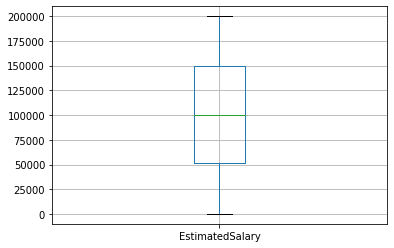

In [20]:
data.boxplot('EstimatedSalary')
plt.show()

### Подготовим выборки для дальнейшего обучения моделей

In [21]:
len(data.query('EstimatedSalary < 20_000'))

909

In [22]:
#Удалим ненужные признаки:
features_ignored = ['RowNumber', 'CustomerId', 'Surname']
data = data.drop(features_ignored, axis=1)

In [23]:
#Зафиксируем псевдослучайность для всех используемых в проекте алгоритмов:
rnd_state = 12345

In [24]:
#Определим несколько функций, которые пригодятся в дальнейшем и избавят нас от дублирования кода.

def tf(data, target_column='Exited'):
    '''Функция возвращает целевой признак и признаки для обучения модели.'''    
    target = data[target_column]
    features = data.drop(target_column, axis=1)
    return target, features

Спрятанной тестовой выборки в задании нет, поэтому будем разбивать исходный набор данных на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов сделаем равными.

In [25]:
def split_data(features, target):
    '''
    Функция разделяет заданный датасет на обучающую, валидационную и тестовую выборки:
    60% | 20% | 20%
    '''
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.4, random_state=rnd_state
    )

    features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid, target_valid, test_size=0.5, random_state=rnd_state
    )
    
    # выполним масштабирование количественных признаков
    scaler = StandardScaler()
    numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_valid, features_test, target_train, target_valid, target_test

In [26]:
def train_and_predict(data, model, log_prefix='', samplefunc=None, test=False):
    '''Функция возвращает обученную модель.'''
    target, features = tf(data)
    features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)
    
    if samplefunc:
        features_train, target_train = samplefunc(features_train, target_train)
    
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print(f'{log_prefix}F1-мера на валидационной выборке: {f1_score(target_valid, predicted_valid)}')
    
    if test:
        predictions_test = model.predict(features_test)
        print(f'{log_prefix}F1-мера на тестовой выборке: {f1_score(target_test, predicted_test)}')
    
    return model

#### Выводы
Датасет состоит из 10 000 объектов и 14 признаков. Из них для обучения модели нам не понадобятся:

- RowNumber индекс строки в данных;
- CustomerId уникальный идентификатор;
- Surname фамилия клиента.

Целевой признак для нашей задачи – Exited. Модель, которую мы построим, будет предсказывать 
- значение 1 если клиент уйдет 
- значение 0 если клиент останется   
Это задача бинарной классификации.


В датасете представлены клиенты из трех стран EC: 
- Франции ~50% 
- Германии ~25%
- Испании ~25%.
Следовательно, все денежные суммы указаны в евро €.

Признак Tenure (количество недвижимости у клиента) содержит 909 пропусков. Мы их удалили и привели признак к целочисленному типу.

У 3 617 клиентов банка нулевой баланс на счете. Такая ситуация может быть вполне реалистичной – не у всех клиентов может быть положительный баланс, особенно при условии бесплатного обслуживания. В реальной практике мы бы обязательно уточнили этот момент у коллег. Если бы мы убрали объекты, у которых баланс меньше 25 000 (это видно по гистограмме), то есть шанс, что модель будет плохо предсказывать в подобных случаях.
Заметим, что предполагаемая зарплата EstimatedSalary имеет странности: нижний ус упирается в близкое к нулю значение, но при этом первый квартиль лежит на урове €50 000. Как и в случае с балансом, мы могли бы уточнить как формируется данный признак, например, заполняет его клиент или же предсказывает другая модель. Оставим как есть, вдруг кто-то живет на дивиденды от недвижимости или временно проживает в стране.

# 2. Исследование задачи

In [27]:
# Отключим предупреждения для того, чтобы успешно смаштабировать количественные признаки
pd.options.mode.chained_assignment = None

Проверим, как часто в целевом признаке нашего исходного датасета встречается класс «1» или «0»:

0    0.796062
1    0.203938
Name: Exited, dtype: float64


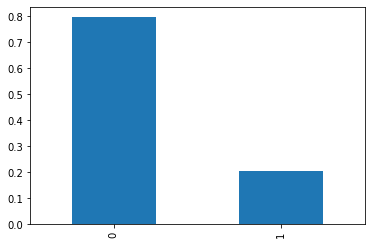

In [28]:
class_frequency = data['Exited'].value_counts(normalize=True)
class_frequency.plot(kind='bar')
print(class_frequency)
plt.show()

Соотношение классов далеко от 1:1, т.е. они несбалансированы: ~80% отрицательных и ~20% положительных.

> На данном этапе мы будем исследовать модели без учета дисбаланса классов, заведомо ожидая плохие результаты.

Также на этапе подготовки данных мы увидили, что часть признаков нашего датасета – категориальные. Для обучения модели логистической регрессии нам потребуется преобразовать категориальные признаки прямым кодированием, а для обучения модели решающего дерева или случайного леса выполнить порядковое кодирование.

## Логистическая регрессия

In [29]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [30]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model)

F1-мера на валидационной выборке: 0.30400000000000005


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

При дисбалансе классов логистическая регрессия предсказывает крайне плохо.

Перед тем, как экспериментировать с моделями дерева решений и случайного леса, воспользуемся техникой порядкового кодирования для категориальных признаков.

In [31]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)

## Дерево решений

In [32]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1-мера на валидационной выборке: 0.5304878048780488
max_depth 4:	F1-мера на валидационной выборке: 0.5414551607445008
max_depth 6:	F1-мера на валидационной выборке: 0.5106382978723404
max_depth 8:	F1-мера на валидационной выборке: 0.5085910652920962
max_depth 10:	F1-мера на валидационной выборке: 0.5421133231240429
max_depth 12:	F1-мера на валидационной выборке: 0.5
max_depth 14:	F1-мера на валидационной выборке: 0.4798927613941019
max_depth 16:	F1-мера на валидационной выборке: 0.4746666666666667
max_depth 18:	F1-мера на валидационной выборке: 0.4562334217506631
max_depth 20:	F1-мера на валидационной выборке: 0.45144356955380577


Пока лучшие результаты 0.5421133231240429 получили у модели с глубиной равной 10.

## Случайный лес

В качестве гиперпараметра глубины дерева возьмем значение, найденное для предыдущей модели. А количество деревьев для нашего случайного леса будет искать в диапазоне от 10 до 200 с шагом 10.

In [33]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=10, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1-мера на валидационной выборке: 0.5690235690235691
n_estimators = 20:	F1-мера на валидационной выборке: 0.5724020442930153
n_estimators = 30:	F1-мера на валидационной выборке: 0.5830508474576271
n_estimators = 40:	F1-мера на валидационной выборке: 0.5733788395904437
n_estimators = 50:	F1-мера на валидационной выборке: 0.5660377358490567
n_estimators = 60:	F1-мера на валидационной выборке: 0.5655172413793104
n_estimators = 70:	F1-мера на валидационной выборке: 0.5660377358490567
n_estimators = 80:	F1-мера на валидационной выборке: 0.5660377358490567
n_estimators = 90:	F1-мера на валидационной выборке: 0.5565217391304348
n_estimators = 100:	F1-мера на валидационной выборке: 0.5640138408304498
n_estimators = 110:	F1-мера на валидационной выборке: 0.5555555555555556
n_estimators = 120:	F1-мера на валидационной выборке: 0.5555555555555556
n_estimators = 130:	F1-мера на валидационной выборке: 0.5580589254766032
n_estimators = 140:	F1-мера на валидационной выборке: 0.5611

Модель случайного леса предсказывает чуть лучше, чем дерево решений. Лучший результат 0.5830508474576271 достигается при количестве деревьев равном 30.

# 3. Борьба с дисбалансом

### Взвешивание классов
Придадим объектам редкого класса 1 больший вес используя гиперпараметр class_weight='balanced'.

#### Логистическая регрессия

In [27]:
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model)

F1-мера на валидационной выборке: 0.509731232622799


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

Значение F1-меры для логистической регрессии увеличилось

#### Дерево решений

In [28]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(class_weight='balanced', max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1-мера на валидационной выборке: 0.5297619047619048
max_depth 4:	F1-мера на валидационной выборке: 0.5045492142266335
max_depth 6:	F1-мера на валидационной выборке: 0.574370709382151
max_depth 8:	F1-мера на валидационной выборке: 0.5362637362637362
max_depth 10:	F1-мера на валидационной выборке: 0.4988962472406181
max_depth 12:	F1-мера на валидационной выборке: 0.4895104895104895
max_depth 14:	F1-мера на валидационной выборке: 0.4809160305343511
max_depth 16:	F1-мера на валидационной выборке: 0.4708994708994709
max_depth 18:	F1-мера на валидационной выборке: 0.472630173564753
max_depth 20:	F1-мера на валидационной выборке: 0.4777327935222672


Для дерева решений с глубиной 10 (что было у нас) F1 - мера уменьшилась. Но увеличилась для глубины 6

#### Случайный лес

In [38]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(class_weight='balanced', n_estimators=estim, max_depth=10, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1-мера на валидационной выборке: 0.59874213836478
n_estimators = 20:	F1-мера на валидационной выборке: 0.6209573091849936
n_estimators = 30:	F1-мера на валидационной выборке: 0.6266318537859008
n_estimators = 40:	F1-мера на валидационной выборке: 0.6310299869621904
n_estimators = 50:	F1-мера на валидационной выборке: 0.6266318537859008
n_estimators = 60:	F1-мера на валидационной выборке: 0.6204188481675392
n_estimators = 70:	F1-мера на валидационной выборке: 0.6258148631029987
n_estimators = 80:	F1-мера на валидационной выборке: 0.6274509803921569
n_estimators = 90:	F1-мера на валидационной выборке: 0.6290956749672346
n_estimators = 100:	F1-мера на валидационной выборке: 0.6194225721784776
n_estimators = 110:	F1-мера на валидационной выборке: 0.6261558784676355
n_estimators = 120:	F1-мера на валидационной выборке: 0.6254927726675427
n_estimators = 130:	F1-мера на валидационной выборке: 0.6340819022457067
n_estimators = 140:	F1-мера на валидационной выборке: 0.631439

А вот модель случайного леса показывает самое высокое значение F1-меры: 0.6318537859007833 при количестве деревьев равном 160.

### Увеличение выборки

Cделаем объекты редкого класса не такими редкими и переобучим модели.

In [30]:
def upsample(features, target, repeat=10):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=rnd_state)
    
    return features_upsampled, target_upsampled

#### Логистическая регрессия

In [31]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model, samplefunc=upsample)

F1-мера на валидационной выборке: 0.41538461538461535


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

#### Дерево решений

In [32]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=upsample, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1-мера на валидационной выборке: 0.5100788781770377
max_depth 4:	F1-мера на валидационной выборке: 0.4598786244099798
max_depth 6:	F1-мера на валидационной выборке: 0.5321100917431193
max_depth 8:	F1-мера на валидационной выборке: 0.4886452623335944
max_depth 10:	F1-мера на валидационной выборке: 0.4908616187989556
max_depth 12:	F1-мера на валидационной выборке: 0.4820213799805637
max_depth 14:	F1-мера на валидационной выборке: 0.4722222222222222
max_depth 16:	F1-мера на валидационной выборке: 0.46539379474940334
max_depth 18:	F1-мера на валидационной выборке: 0.463130659767141
max_depth 20:	F1-мера на валидационной выборке: 0.4489247311827957


#### Случайный лес

In [39]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=10, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=upsample, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1-мера на валидационной выборке: 0.5602836879432624
n_estimators = 20:	F1-мера на валидационной выборке: 0.5552608311229001
n_estimators = 30:	F1-мера на валидационной выборке: 0.5631067961165048
n_estimators = 40:	F1-мера на валидационной выборке: 0.5625554569653949
n_estimators = 50:	F1-мера на валидационной выборке: 0.5589285714285714
n_estimators = 60:	F1-мера на валидационной выборке: 0.5655296229802513
n_estimators = 70:	F1-мера на валидационной выборке: 0.5673249551166966
n_estimators = 80:	F1-мера на валидационной выборке: 0.573502722323049
n_estimators = 90:	F1-мера на валидационной выборке: 0.5729729729729729
n_estimators = 100:	F1-мера на валидационной выборке: 0.5701275045537341
n_estimators = 110:	F1-мера на валидационной выборке: 0.5714285714285714
n_estimators = 120:	F1-мера на валидационной выборке: 0.572463768115942
n_estimators = 130:	F1-мера на валидационной выборке: 0.5698630136986301
n_estimators = 140:	F1-мера на валидационной выборке: 0.571167

Значение F1-меры у каждой из рассмотренных моделей меньше, чем в случае балансировки классов.

### Уменьшение выборки

In [34]:
def downsample(features, target, fraction = 0.2):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=rnd_state)] + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=rnd_state)] + [target_ones]
    )
    
    return features_downsampled, target_downsampled

#### Логистическая регрессия

In [35]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model, samplefunc=downsample)

F1-мера на валидационной выборке: 0.48878205128205127


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

#### Дерево решений

In [36]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=downsample, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1-мера на валидационной выборке: 0.5100788781770377
max_depth 4:	F1-мера на валидационной выборке: 0.5242399342645849
max_depth 6:	F1-мера на валидационной выборке: 0.533003300330033
max_depth 8:	F1-мера на валидационной выборке: 0.5238938053097345
max_depth 10:	F1-мера на валидационной выборке: 0.5340699815837937
max_depth 12:	F1-мера на валидационной выборке: 0.5057880676758681
max_depth 14:	F1-мера на валидационной выборке: 0.497391304347826
max_depth 16:	F1-мера на валидационной выборке: 0.4861111111111111
max_depth 18:	F1-мера на валидационной выборке: 0.49043478260869566
max_depth 20:	F1-мера на валидационной выборке: 0.49043478260869566


#### Случайный лес

In [40]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=10, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=downsample, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1-мера на валидационной выборке: 0.5529308836395451
n_estimators = 20:	F1-мера на валидационной выборке: 0.5557491289198606
n_estimators = 30:	F1-мера на валидационной выборке: 0.5598591549295774
n_estimators = 40:	F1-мера на валидационной выборке: 0.5630550621669628
n_estimators = 50:	F1-мера на валидационной выборке: 0.5563380281690141
n_estimators = 60:	F1-мера на валидационной выборке: 0.5575221238938053
n_estimators = 70:	F1-мера на валидационной выборке: 0.5597874224977857
n_estimators = 80:	F1-мера на валидационной выборке: 0.5580985915492959
n_estimators = 90:	F1-мера на валидационной выборке: 0.5574057843996495
n_estimators = 100:	F1-мера на валидационной выборке: 0.558180227471566
n_estimators = 110:	F1-мера на валидационной выборке: 0.5608465608465609
n_estimators = 120:	F1-мера на валидационной выборке: 0.5583845478489903
n_estimators = 130:	F1-мера на валидационной выборке: 0.5633802816901409
n_estimators = 140:	F1-мера на валидационной выборке: 0.56014

Значение F1-меры у каждой из рассмотренных моделей меньше, чем в случае балансировки классов.

# 4. Тестирование модели

На основе наших экспериментов с моделями можем сделать вывод, что лучшей моделью является случайный лес с количеством деревьев равным 160 и глубиной равной 10 с учетом балансировки классов.

>F1 - мера = 0.6318537859007833

Протестируем модель на тестовой выборке:

In [41]:
target, features = tf(data_ordinal)
features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)

model = RandomForestClassifier(class_weight='balanced', n_estimators=160, max_depth=10, random_state=rnd_state)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
print('valid:', f1_score(target_valid, predicted_valid))

predicted_test = model.predict(features_test)
print('test:', f1_score(target_test, predicted_test))

valid: 0.6318537859007833
test: 0.5965909090909091


Посчитаем AUC-ROC для нашей модели и посмотрим насколько она лучше случайной модели:

In [43]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_auc_score(target_valid, probabilities_one_valid)

0.8625917383485164

AUC-ROC случайной модели равна 0.8626 – наша метрика выше и понемногу стремиться к недостижимой едицине.

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*